Extract cell type markers from edgeR-pseudobulk DEA of ABC Atlas (Yao 2023 Nature)

See other scripts for processing and edgeR DEA

In [1]:
import collections
import os
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
os.environ["CONDA_DEFAULT_ENV"]

'scanpy'

In [5]:
os.chdir("/Users/simonf/PhD/Git-mac/cellseg-benchmark")
main_dir = "./data"

In [6]:
!ls -l data

total 0
drwxr-xr-x  5 simonf  staff  160 Apr 15 17:54 ABCAtlas_Yao2023Nature


In [7]:
tdate = "20250130"
tdate = "20250416"  # new cell type arrangement

df = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        tdate + "_DEA_QL_def_incllib.csv",
    ),
    index_col=0,
)
# using most stringent QL edgeR method including library_method as covariate, see other script
df["gene"] = df["gene"].astype("str")
df["cell_type"] = df["cell_type"].astype("category")
df["test"] = df["test"].astype("category")
df["nlog(pvalue)"] = -np.log10(df["PValue"])
df["significant"] = (df["FDR"] < 1e-6) & (abs(df["logFC"]) > 2)
df = df.sort_values(by=["logFC"], ascending=[False])
df.head(2)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant
Ttr,Ttr,Choroid-Plexus,Choroid-Plexus_vs_others,135.181785,4.940513e+40,8.132041,799.587782,4.256697e-158,6.005176e-156,157.370927,True
2900040C04Rik,2900040C04Rik,Choroid-Plexus,Choroid-Plexus_vs_others,127.661904,2.691921e+38,2.018167,802.704368,2.537594e-145,3.041020e-143,144.595578,True


In [8]:
# df.dtypes

## Volcano plots

In [9]:
# Get global limits
x_min, x_max = df["logFC"].quantile([1e-5, 1 - 1e-5])
y_max = df["nlog(pvalue)"][~np.isinf(df["nlog(pvalue)"])].max()
y_min = df["nlog(pvalue)"].min()

In [10]:
df["nlog(pvalue)"][~np.isinf(df["nlog(pvalue)"])].max()

323.3062153431158

In [11]:
df.head(2)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant
Ttr,Ttr,Choroid-Plexus,Choroid-Plexus_vs_others,135.181785,4.940513e+40,8.132041,799.587782,4.256697e-158,6.005176e-156,157.370927,True
2900040C04Rik,2900040C04Rik,Choroid-Plexus,Choroid-Plexus_vs_others,127.661904,2.691921e+38,2.018167,802.704368,2.537594e-145,3.041020e-143,144.595578,True


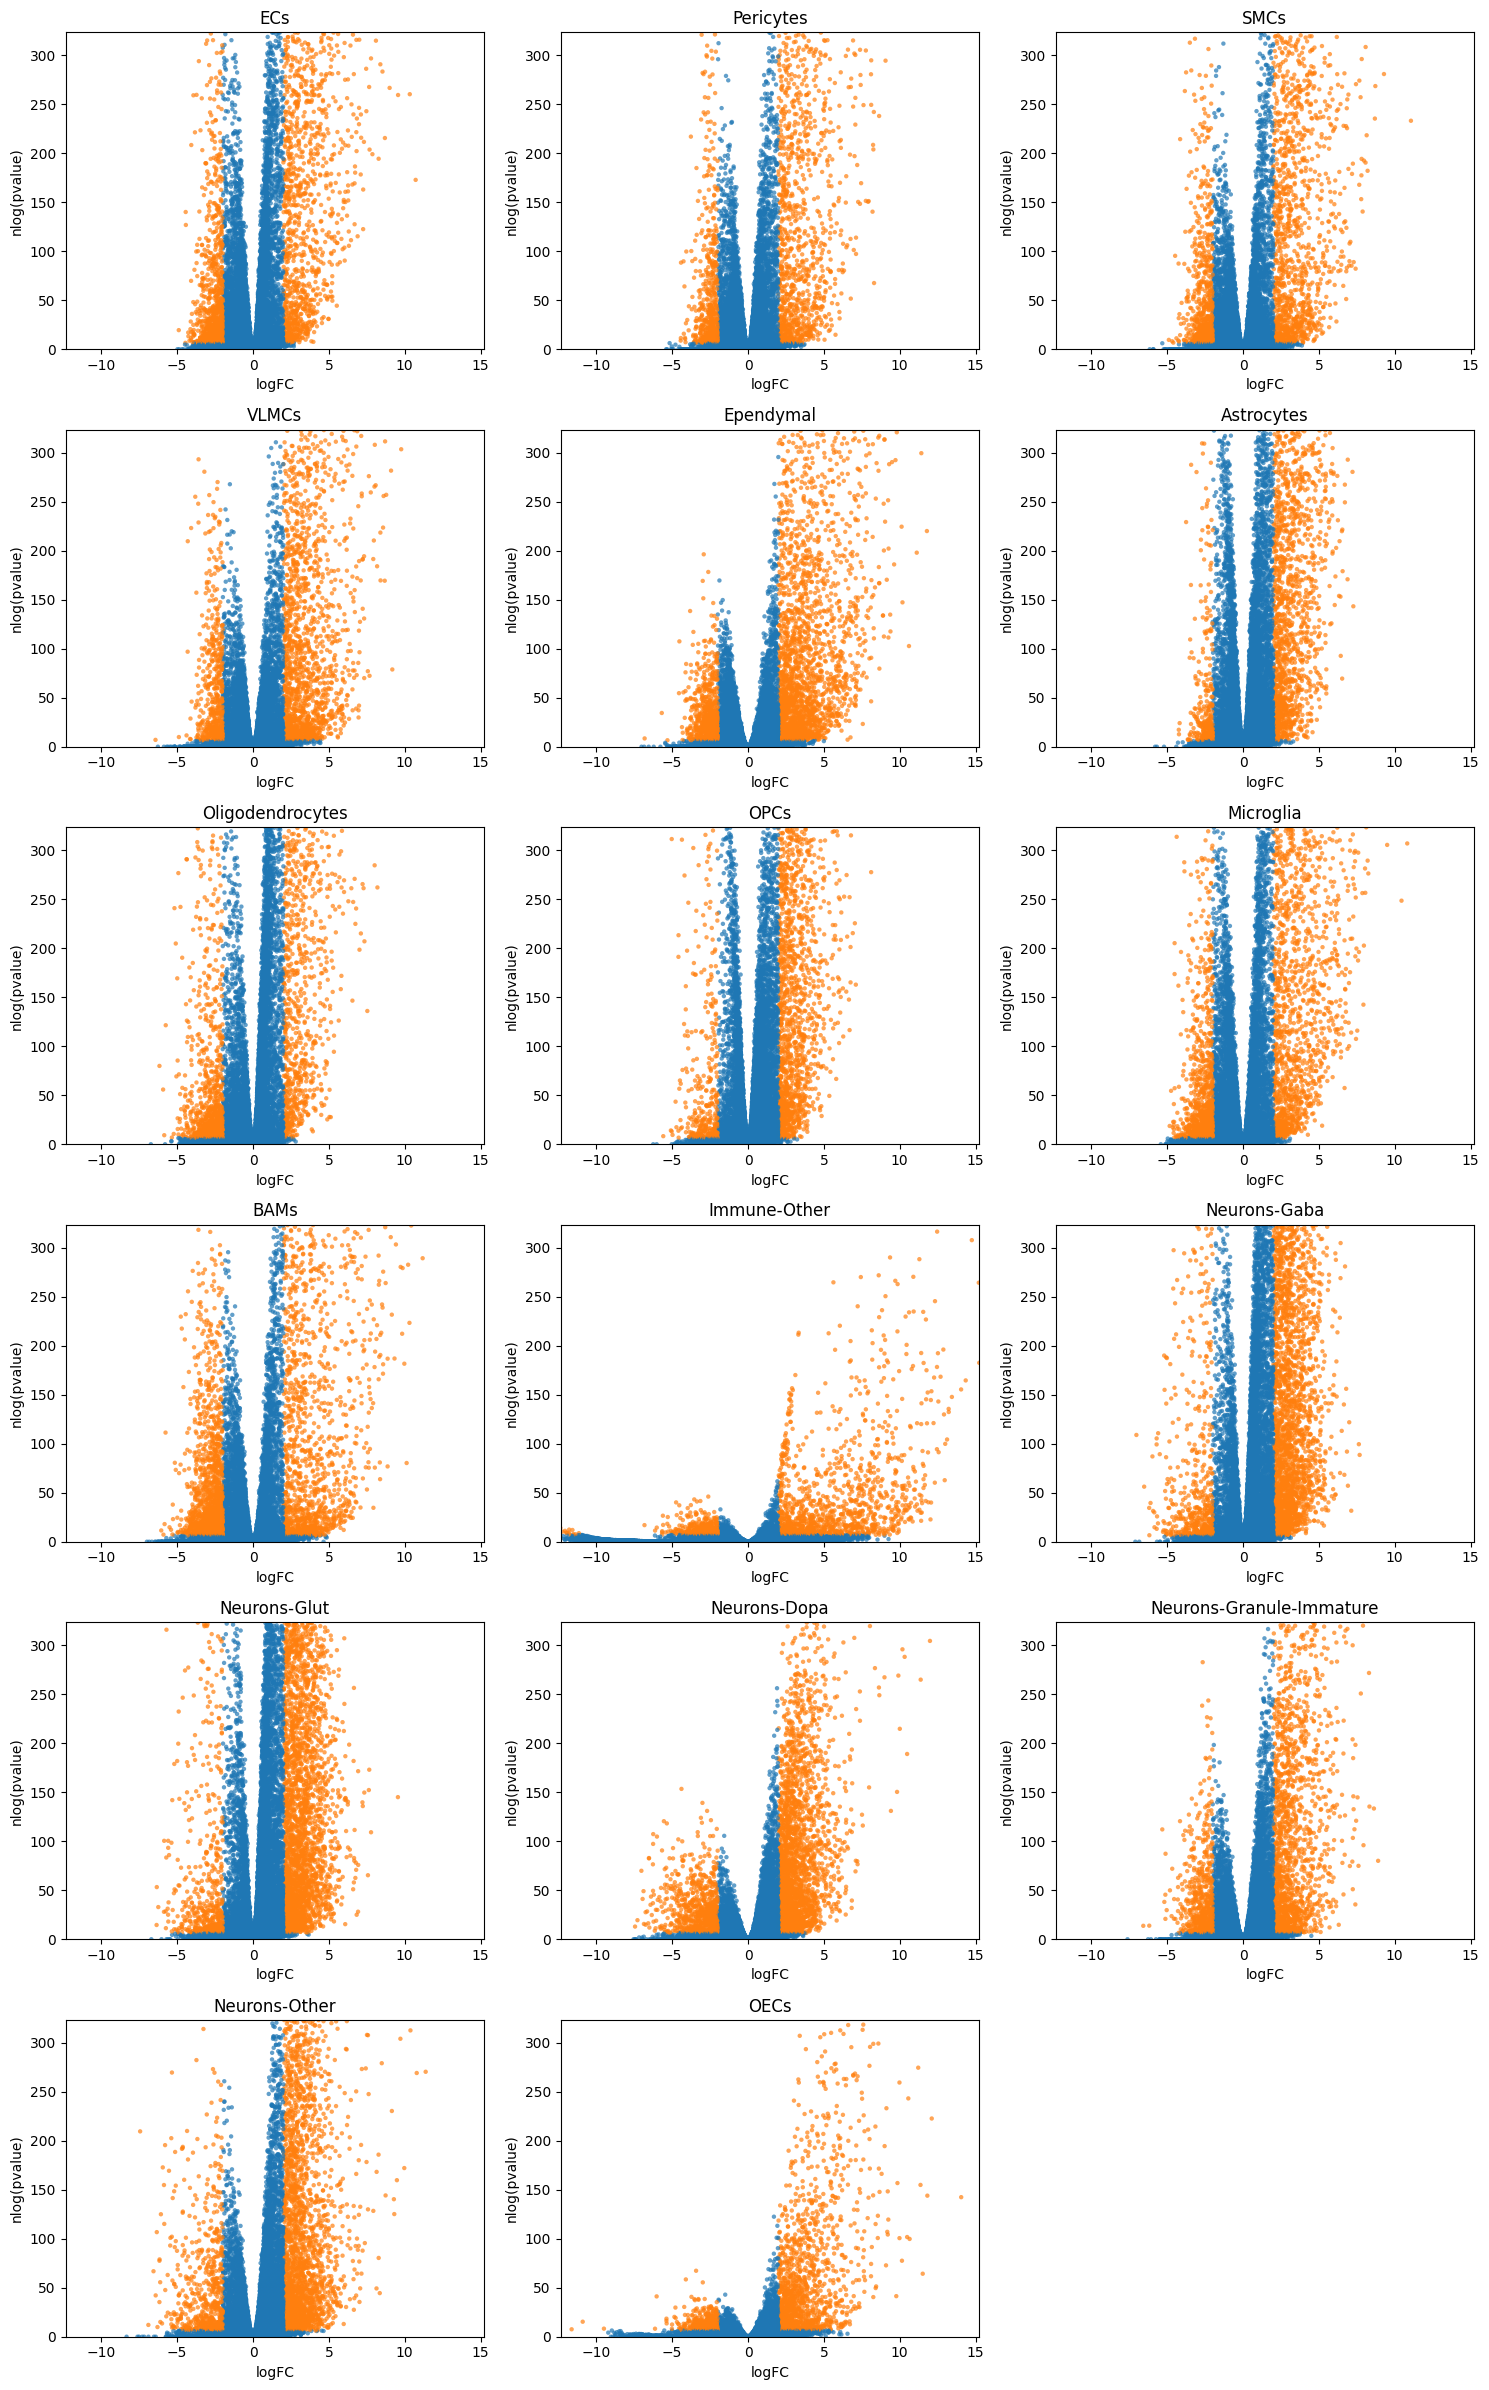

In [12]:
cell_type_order = [
    "ECs",
    "Pericytes",
    "SMCs",
    "VLMCs",
    "Ependymal",
    "Choroid Plexus",
    "Astrocytes",
    "Oligodendrocytes",
    "OPCs",
    "Microglia",
    "BAMs",
    "Immune-Other",
    "Neurons-Gaba",
    "Neurons-Glut",
    "Neurons-Dopa",
    "Neurons-Immature",
    "Neurons-Granule-Immature",
    "Neurons-Other",
    "OECs",
    "Undefined",
]
cell_types = [ct for ct in cell_type_order if ct in df["cell_type"].unique()]
n_cols = min(3, len(cell_types))
n_rows = int(np.ceil(len(cell_types) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for ax, cell_type in zip(axes, cell_types):
    df_sub = df[df["cell_type"] == cell_type].copy()
    # rename duplicated gene names
    df_sub["gene"] += "." + (df_sub.groupby("gene").cumcount() + 1).astype(str)
    df_sub.index = df_sub["gene"]
    sns.scatterplot(
        data=df_sub,
        x="logFC",
        y="nlog(pvalue)",
        hue="significant",
        s=10,
        alpha=0.7,
        legend=False,
        edgecolor="none",
        ax=ax,
    )
    ax.set_title(cell_type)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)

for ax in axes[len(cell_types) :]:
    ax.remove()

plt.tight_layout()
plt.show()

## Top 20 markers

Note: Many overlaps  
Note 2: arbitrary thresholds

In [13]:
fdr_threshold = 1e-05

In [14]:
# sub = df[df["cell_type"] == "Bergmann"]
# sub.head(15)

In [15]:
df["significant_positive"] = (df["FDR"] < fdr_threshold) & (df["logFC"] > 2)

In [16]:
df_sign = df[df["significant_positive"]]
df_sign = df_sign.sort_values(by=["logFC"], ascending=[False])
df_sign.shape

(51630, 12)

In [17]:
# keep only top x% logCPM genes per cell type
df_sign = (
    df_sign.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.25), "logCPM"))
    .reset_index(drop=True)
)
df_sign = df_sign.sort_values(by=["logFC"], ascending=[False])

In [18]:
df_sign = df_sign.sort_values(by=["logFC"], ascending=[False])
df_sign.shape

(12898, 12)

In [19]:
# remaining available marker genes per cell type
remainders = df_sign["cell_type"].value_counts()
remainders

Neurons-Glut                945
Neurons-Gaba                830
Neurons-Other               727
Neurons-Glyc-Gaba           726
Ependymal                   723
Neurons-Dopa                672
Microglia                   646
Astrocytes                  559
Neurons-Dopa-Gaba           540
OPCs                        532
VLMCs                       530
ECs                         523
BAMs                        492
Neurons-Granule-Immature    476
SMCs                        465
Oligodendrocytes            452
Bergmann                    413
Tanycytes                   408
Pericytes                   402
Choroid-Plexus              391
Astroependymal              377
ABCs                        375
OECs                        367
Immune-Other                327
Name: cell_type, dtype: int64

In [20]:
# drop cell types with <X specific marker genes
outs = remainders[remainders < 20].index.tolist()
outs

[]

In [21]:
df_sign = df_sign[~df_sign["cell_type"].isin(outs)]

In [22]:
# Get top 20 per cell type
top20_per_type = {}
for cell_type in df_sign["cell_type"].unique():
    top20_per_type[cell_type] = (
        df_sign[df_sign["cell_type"] == cell_type]["gene"].head(20).tolist()
    )

In [23]:
result = pd.DataFrame(top20_per_type)

In [26]:
# Save
result.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d") + "_cell_type_markers_top20.csv",
    ),
    index=False,
)
os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "marker_genes_df",
    date.today().strftime("%Y%m%d") + "_cell_type_markers_top20.csv",
)

'./data/ABCAtlas_Yao2023Nature/marker_genes_df/20250416_cell_type_markers_top20.csv'

In [28]:
result

,Choroid-Plexus,BAMs,Ependymal,SMCs,Microglia,Pericytes,VLMCs,Immune-Other,ECs,ABCs,...,Neurons-Granule-Immature,Astroependymal,Astrocytes,Neurons-Other,Tanycytes,Bergmann,Neurons-Dopa-Gaba,Neurons-Gaba,Neurons-Glyc-Gaba,Neurons-Glut
0,Ttr,Pf4,Ccdc153,Acta2,Tnf,Higd1b,Slc6a13,Mir142hg,Ly6c1,Mgp,...,Dlx6os1,Gfap,Atp13a4,Slc18a2,Six3,Gpr37l1,Chrm2,Dlx6os1,Pvalb,Slc17a6
1,Igf2,Cd163,Tmem212,Myh11,Mir142hg,Abcc9,Dcn,Lyz2,Adgrl4,Tbx18,...,Gm38505,Aqp4,Gm12239,Ddc,Dnah12,Slc1a3,Dlk1,Pvalb,Slc32a1,Nrg3os
2,Enpp2,F13a1,Dnah12,Tagln,Siglech,Ndufa4l2,Tbx18,Ikzf1,Slco1a4,Fn1,...,Sox11,Agt,Gm20713,Dlk1,Col23a1,S1pr1,Nxph1,Vip,Gm32647,Slc17a7
3,Htr2c,Lyz2,Dnah6,Carmn,P2ry13,Slc38a11,Igf2,Tyrobp,Flt1,Ogn,...,Dcx,Slc7a11,Gm6145,Chrm2,Tbx3,Acsbg1,Cdh12,Sst,6330411D24Rik,Hs3st4
4,Rbm47,Mrc1,Gm19935,Slc38a11,Gm10790,Tbx3os1,Col1a1,Cd86,Cldn5,Cdh5,...,Meis2,Etnppl,Gpc5,Fstl5,6330403K07Rik,Timp4,Cntn5,Slc32a1,Nxph1,Nrn1
5,Igfbp2,Stab1,Rassf9,Higd1b,Ccl4,Vtn,Lama1,Laptm5,Ly6a,Ptgds,...,Myt1,Fabp7,Agt,Elavl2,Mlc1,Hopx,Gad2,Kcnmb2,Nrg3os,Ndst4
6,Slco1c1,Cd86,3300002A11Rik,Pln,C1qc,Rgs5,Edn3,Srgn,Cdh5,Foxc1,...,Bcl11a,Mlc1,Etnppl,6330411D24Rik,Slit2,Gjc3,Kcnc2,Gad2,Klhl1,C1ql3
7,Car14,Adgre1,Foxj1,Myl9,Cd86,Slc6a20a,Fmod,Cd53,Mecom,Abcb1a,...,Foxg1,Atp13a4,Aqp4,Nrg3os,Nnat,Stk32a,Dcx,6330411D24Rik,Htr2c,Gm20642
8,Slc6a20a,P2ry6,Ankub1,Crispld2,Ikzf1,Adap2,Foxd1,Itgam,Zfp366,Dcn,...,Adarb2,Rfx4,Slc7a10,A230006K03Rik,Col25a1,Grid2,Gm32509,Galntl6,Gad2,Dpp10
9,Atp2b3,Fcrls,Ecrg4,Rgs5,Tmem119,Lamc3,Cemip,Dock2,Abcb1a,Anxa3,...,Sox2ot,Ednrb,Slco1c1,Gm26871,Acss3,Gm6145,Synpr,Nrg3os,Fstl5,Gm32647


In [29]:
# number of duplicates genes
duplicates = {
    key: value
    for key, value in collections.Counter(result.values.flatten()).items()
    if value > 1
}
len(duplicates)

102

## Top 50 markers

Note: Many overlaps  
Note 2: arbitrary thresholds

In [30]:
fdr_threshold = 1e-05

In [31]:
# sub = df[df["cell_type"] == "Bergmann"]
# sub.head(15)

In [32]:
df["significant_positive"] = (df["FDR"] < fdr_threshold) & (df["logFC"] > 2)

In [33]:
df_sign = df[df["significant_positive"]]
df_sign = df_sign.sort_values(by=["logFC"], ascending=[False])
df_sign.shape

(51630, 12)

In [34]:
# keep only top x% logCPM genes per cell type
df_sign = (
    df_sign.groupby("cell_type")
    .apply(lambda x: x.nlargest(int(len(x) * 0.25), "logCPM"))
    .reset_index(drop=True)
)
df_sign = df_sign.sort_values(by=["logFC"], ascending=[False])

In [35]:
df_sign = df_sign.sort_values(by=["logFC"], ascending=[False])
df_sign.shape

(12898, 12)

In [36]:
# remaining available marker genes per cell type
remainders = df_sign["cell_type"].value_counts()
remainders

Neurons-Glut                945
Neurons-Gaba                830
Neurons-Other               727
Neurons-Glyc-Gaba           726
Ependymal                   723
Neurons-Dopa                672
Microglia                   646
Astrocytes                  559
Neurons-Dopa-Gaba           540
OPCs                        532
VLMCs                       530
ECs                         523
BAMs                        492
Neurons-Granule-Immature    476
SMCs                        465
Oligodendrocytes            452
Bergmann                    413
Tanycytes                   408
Pericytes                   402
Choroid-Plexus              391
Astroependymal              377
ABCs                        375
OECs                        367
Immune-Other                327
Name: cell_type, dtype: int64

In [37]:
# drop cell types with <X specific marker genes
outs = remainders[remainders < 50].index.tolist()
outs

[]

In [38]:
df_sign = df_sign[~df_sign["cell_type"].isin(outs)]

In [39]:
# Get top 50 per cell type
top50_per_type = {}
for cell_type in df_sign["cell_type"].unique():
    top50_per_type[cell_type] = (
        df_sign[df_sign["cell_type"] == cell_type]["gene"].head(50).tolist()
    )

In [40]:
result = pd.DataFrame(top50_per_type)

In [41]:
# Save
result.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d") + "_cell_type_markers_top50.csv",
    ),
    index=False,
)
os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "marker_genes_df",
    date.today().strftime("%Y%m%d") + "_cell_type_markers_top50.csv",
)

'./data/ABCAtlas_Yao2023Nature/marker_genes_df/20250416_cell_type_markers_top50.csv'

In [42]:
result

,Choroid-Plexus,BAMs,Ependymal,SMCs,Microglia,Pericytes,VLMCs,Immune-Other,ECs,ABCs,...,Neurons-Granule-Immature,Astroependymal,Astrocytes,Neurons-Other,Tanycytes,Bergmann,Neurons-Dopa-Gaba,Neurons-Gaba,Neurons-Glyc-Gaba,Neurons-Glut
0,Ttr,Pf4,Ccdc153,Acta2,Tnf,Higd1b,Slc6a13,Mir142hg,Ly6c1,Mgp,...,Dlx6os1,Gfap,Atp13a4,Slc18a2,Six3,Gpr37l1,Chrm2,Dlx6os1,Pvalb,Slc17a6
1,Igf2,Cd163,Tmem212,Myh11,Mir142hg,Abcc9,Dcn,Lyz2,Adgrl4,Tbx18,...,Gm38505,Aqp4,Gm12239,Ddc,Dnah12,Slc1a3,Dlk1,Pvalb,Slc32a1,Nrg3os
2,Enpp2,F13a1,Dnah12,Tagln,Siglech,Ndufa4l2,Tbx18,Ikzf1,Slco1a4,Fn1,...,Sox11,Agt,Gm20713,Dlk1,Col23a1,S1pr1,Nxph1,Vip,Gm32647,Slc17a7
3,Htr2c,Lyz2,Dnah6,Carmn,P2ry13,Slc38a11,Igf2,Tyrobp,Flt1,Ogn,...,Dcx,Slc7a11,Gm6145,Chrm2,Tbx3,Acsbg1,Cdh12,Sst,6330411D24Rik,Hs3st4
4,Rbm47,Mrc1,Gm19935,Slc38a11,Gm10790,Tbx3os1,Col1a1,Cd86,Cldn5,Cdh5,...,Meis2,Etnppl,Gpc5,Fstl5,6330403K07Rik,Timp4,Cntn5,Slc32a1,Nxph1,Nrn1
5,Igfbp2,Stab1,Rassf9,Higd1b,Ccl4,Vtn,Lama1,Laptm5,Ly6a,Ptgds,...,Myt1,Fabp7,Agt,Elavl2,Mlc1,Hopx,Gad2,Kcnmb2,Nrg3os,Ndst4
6,Slco1c1,Cd86,3300002A11Rik,Pln,C1qc,Rgs5,Edn3,Srgn,Cdh5,Foxc1,...,Bcl11a,Mlc1,Etnppl,6330411D24Rik,Slit2,Gjc3,Kcnc2,Gad2,Klhl1,C1ql3
7,Car14,Adgre1,Foxj1,Myl9,Cd86,Slc6a20a,Fmod,Cd53,Mecom,Abcb1a,...,Foxg1,Atp13a4,Aqp4,Nrg3os,Nnat,Stk32a,Dcx,6330411D24Rik,Htr2c,Gm20642
8,Slc6a20a,P2ry6,Ankub1,Crispld2,Ikzf1,Adap2,Foxd1,Itgam,Zfp366,Dcn,...,Adarb2,Rfx4,Slc7a10,A230006K03Rik,Col25a1,Grid2,Gm32509,Galntl6,Gad2,Dpp10
9,Atp2b3,Fcrls,Ecrg4,Rgs5,Tmem119,Lamc3,Cemip,Dock2,Abcb1a,Anxa3,...,Sox2ot,Ednrb,Slco1c1,Gm26871,Acss3,Gm6145,Synpr,Nrg3os,Fstl5,Gm32647


In [43]:
# number of duplicates genes
duplicates = {
    key: value
    for key, value in collections.Counter(result.values.flatten()).items()
    if value > 1
}
len(duplicates)

316

## Top X specific markers

= not expressed in other cell types

For using in incongrunecy analysis

### Option A1: Remove all duplicates

Best option

Exclude any genes with FDR<fdr_thresh & logFC>2 in >1 cell type

Issues:

- arbitrary thresholds
- excludes many genes

In [44]:
topx = 5
topx = 15

In [45]:
dftemp = df_sign.copy()

In [46]:
dftemp.groupby("cell_type")["logCPM"].mean().sort_values(ascending=False)

cell_type
Oligodendrocytes            7.445136
OPCs                        7.194302
Neurons-Dopa-Gaba           7.126201
OECs                        6.996382
Bergmann                    6.994624
Neurons-Dopa                6.949431
Immune-Other                6.936221
Neurons-Glyc-Gaba           6.862848
Neurons-Gaba                6.855708
Neurons-Other               6.815399
Astrocytes                  6.737327
Neurons-Glut                6.733334
Astroependymal              6.518682
Neurons-Granule-Immature    6.511213
SMCs                        6.473430
Pericytes                   6.468802
ECs                         6.437820
Choroid-Plexus              6.254932
ABCs                        6.142983
Microglia                   5.998937
BAMs                        5.952518
VLMCs                       5.918090
Tanycytes                   5.767900
Ependymal                   4.963813
Name: logCPM, dtype: float64

In [47]:
# drop small cell types and those overlapping with Neurons-GABA, because of large marker gene overlap
if topx == 5:
    ct_exclude = ["Neurons-Dopa-Gaba", "Neurons-Glyc-Gaba", "Neurons-Dopa"]
if topx == 15:
    ct_exclude = [
        "Bergmann",
        "OECs",
        "ABCs",
        "Neurons-Dopa-Gaba",
        "Neurons-Glyc-Gaba",
        "Neurons-Dopa",
        "Neurons-Other",
    ]
dftemp = dftemp[~dftemp["cell_type"].isin(ct_exclude)]
dftemp["cell_type"] = (
    dftemp["cell_type"].astype("category").cat.remove_unused_categories()
)

In [48]:
# check for overlapping genes
gene_counts = collections.Counter(dftemp["gene"])
duplicates = [gene for gene, count in gene_counts.items() if count > 1]
len(duplicates)

2318

In [49]:
duplicates[0:5]

['Pf4', 'Acta2', 'Cd163', 'F13a1', 'Myh11']

In [50]:
# filter out overlapping genes
dftemp_sub = dftemp[~dftemp["gene"].isin(duplicates)].copy()

In [51]:
# remaining available marker genes per cell type
remainders = dftemp_sub["cell_type"].value_counts()
remainders

Ependymal                   353
Oligodendrocytes            143
Microglia                   124
Choroid-Plexus              117
Immune-Other                 93
ECs                          87
Neurons-Glut                 84
Neurons-Granule-Immature     81
VLMCs                        66
Astrocytes                   59
BAMs                         57
Tanycytes                    52
SMCs                         42
OPCs                         30
Pericytes                    19
Neurons-Gaba                 17
Astroependymal               11
Name: cell_type, dtype: int64

In [52]:
# drop cell types with <topx specific marker genes
outs = remainders[remainders < topx].index.tolist()
outs

['Astroependymal']

In [53]:
dftemp_sub = dftemp_sub[~dftemp_sub["cell_type"].isin(outs)]

In [54]:
# Get top X specific genes per cell type
dftemp_sub = dftemp_sub.copy().sort_values(by=["logFC"], ascending=[False])
topX_per_type = {}
for cell_type in dftemp_sub["cell_type"].unique():
    topX_per_type[cell_type] = (
        dftemp_sub[dftemp_sub["cell_type"] == cell_type]["gene"].head(topx).tolist()
    )

In [55]:
result = pd.DataFrame(topX_per_type)

In [56]:
result

,Choroid-Plexus,Ependymal,ECs,Microglia,VLMCs,OPCs,Oligodendrocytes,Astrocytes,Neurons-Gaba,Neurons-Granule-Immature,BAMs,Neurons-Glut,SMCs,Tanycytes,Immune-Other,Pericytes
0,Ttr,Ccdc153,Cldn5,Cd33,Fmod,Neu4,Opalin,Gm20713,Vip,Foxg1,Itga4,Ndst4,Tpm1,Scn9a,Rplp0,Ptpn9
1,Slc4a2,Tmem212,Ly6a,Mpeg1,Foxd1,Gal3st1,Ermn,Nkx2-2,Btbd11,Lgr5,Snx8,Sv2b,Thsd4,Tbx2,Rack1,Osbpl3
2,Slc31a1,Dnah6,Abcb1a,Ltc4s,Spp1,Dpyd,Plp1,Sorcs2,Nhs,Syt6,Gm30382,Ctxn2,Myl6,Mest,Rpl12,Trpc1
3,Cab39l,Gm19935,Ptprb,Hck,C1qtnf7,Chst11,Mog,Ptch1,Prkar2b,Gm15398,Rnf150,Nptx1,Crim1,Gpc3,Trerf1,Gpc6
4,Stk39,Rassf9,Tek,Golm1,Foxq1,Ampd3,Cldn11,Ddhd1,Eml5,Hmgb3,Rftn1,Vwc2l,Fbxo32,9430041J12Rik,Rps9,Pten
5,Ifi27,3300002A11Rik,Slc7a5,Zeb2os,Bmp4,Ppp1r14c,Tmem88b,Tnik,Fmn1,Pbx3,Gab3,Pcnx2,Cacnb2,Dio2,Tpt1,Dennd2a
6,Nhsl2,Foxj1,Ddc,Pag1,Eln,Nlgn3,Mobp,Slc1a4,Gng7,Trim59,Clcn5,Mal2,Smarcd3,Gm26802,Rps18,Lims1
7,Tmem237,Ankub1,Slc7a1,Adrb1,Heyl,Nrxn2,Plekhh1,Gk,Impact,Rerg,Nfxl1,Resp18,Arhgef7,Cdh22,Rps11,Tmem134
8,Wipf3,Ecrg4,Eogt,Trim30a,Cnn2,Zfp462,Cnp,Cep85l,Cacna1d,Hmgn2,Wwp1,5330417C22Rik,Itgb1,Gem,Rpl18,Btbd3
9,Arl6ip1,Ak7,Sgms1,Pla2g15,Ndnf,Myrf,Mbp,Paqr7,Stau2,Zfp618,B3galnt1,Slc8a2,Lpp,Ildr2,Rps5,Raph1


In [62]:
# Save
result.to_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        date.today().strftime("%Y%m%d")
        + "_cell_type_markers_top"
        + str(topx)
        + "_specific.csv",
    ),
    index=False,
)
os.path.join(
    main_dir,
    "ABCAtlas_Yao2023Nature",
    "marker_genes_df",
    date.today().strftime("%Y%m%d")
    + "_cell_type_markers_top"
    + str(topx)
    + "_specific.csv",
)

'./data/ABCAtlas_Yao2023Nature/marker_genes_df/20250416_cell_type_markers_top15_specific.csv'

In [63]:
# number of duplicates genes
duplicates = {
    key: value
    for key, value in collections.Counter(result.values.flatten()).items()
    if value > 1
}
len(duplicates)

0

In [64]:
assert len(duplicates) == 0

### Option A2: Exclusive top-X selection

Not used

Approach: Exclude those genes that are in top X genes of >1 cell type.  
From the reaminings genes, take e.g. top 10 marker genes per cell type.  

Issues:

- arbitrary thresholds
- excludes many genes
- some duplicates remain (depending on X)

In [751]:
dftemp = df_sign.copy()

In [752]:
# get top x genes per cell type
topXexcl = 100
topXexl_df = pd.concat(
    [
        dftemp[dftemp["cell_type"] == ct].nlargest(topXexcl, "logFC")
        for ct in dftemp["cell_type"].unique()
    ]
)

In [753]:
topXexl_df.head(2)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,significant_positive
Ccdc153,Ccdc153,Ependymal,Ependymal_vs_others,8.579135,382.452060,5.819469,3655.492752,0.000000e+00,0.000000e+00,inf,True,True
Ttr,Ttr,Ependymal,Ependymal_vs_others,8.294929,314.067003,7.996137,1289.420603,9.933858e-234,2.641165e-231,233.002882,True,True


In [754]:
# check for overlapping genes
gene_counts = collections.Counter(topXexl_df["gene"])
duplicates = [gene for gene, count in gene_counts.items() if count > 1]
len(duplicates)

467

In [755]:
duplicates[0:5]

['Ttr', 'Dnah12', 'Dynlrb2', 'Gm19935', 'Tm4sf1']

In [756]:
# filter out overlapping genes
dftemp_sub = dftemp[~dftemp["gene"].isin(duplicates)].copy()
# dftemp_sub

In [757]:
# remaining available marker genes per cell type
remainders = dftemp_sub["cell_type"].value_counts()
remainders

Oligodendrocytes     111
ECs                  103
Microglia             95
Astrocytes            68
Immune-Other          67
OECs                  52
Pericytes             49
SMCs                  48
OPCs                  44
Neurons-Gaba          36
Neurons-Dopa-Gaba     26
BAMs                  22
VLMCs                 21
Neurons-Glut          21
Neurons-Immature      17
Ependymal             15
Neurons-Other         13
ABCs                   8
Neurons-Glyc-Gaba      1
Neurons-Dopa           0
Bergmann               0
Name: cell_type, dtype: int64

In [758]:
outs = remainders[remainders < 5].index.tolist()
outs

['Neurons-Glyc-Gaba', 'Neurons-Dopa', 'Bergmann']

In [759]:
dftemp_sub = dftemp_sub[~dftemp_sub["cell_type"].isin(outs)]

In [760]:
# Get top X specific genes per cell type
dftemp_sub = dftemp_sub.copy().sort_values(by=["logFC"], ascending=[False])
topX_per_type = {}
for cell_type in dftemp_sub["cell_type"].unique():
    topX_per_type[cell_type] = (
        dftemp_sub[dftemp_sub["cell_type"] == cell_type]["gene"].head(5).tolist()
    )

In [761]:
result = pd.DataFrame(topX_per_type)

In [762]:
result

,Ependymal,ECs,Oligodendrocytes,SMCs,Microglia,OECs,Pericytes,Neurons-Gaba,Neurons-Immature,OPCs,Astrocytes,Neurons-Dopa-Gaba,Neurons-Glut,Immune-Other,VLMCs,Neurons-Other,BAMs,ABCs
0,Ccdc153,Ly6c1,Enpp6,Pln,Cx3cr1,Ptn,Atp13a5,Grid2,Sox11,Lhfpl3,Slc1a2,Nrsn1,Slc17a7,B2m,Cp,Slit3,Stard8,Col25a1
1,Tmem212,Adgrl4,C030029H02Rik,Mylk,P2ry12,Kctd12,Myo1b,Sst,Tubb2b,Megf11,Luzp2,Cdh12,C1ql3,Tmsb4x,Clmp,Elavl2,Itga9,Itgb5
2,3300002A11Rik,Ly6a,Opalin,Pde3a,Hexb,Sash1,Pde8b,Galntl6,Bcl11a,Cacng4,Rgs20,Sema3e,Nrgn,H2-D1,Vwa1,Fam135b,Cfap299,Abcg2
3,Cfap299,Erg,Ermn,Ntn4,Itgb5,Selenop,Dock6,Cnr1,Stmn1,Itga9,Plpp3,Celf4,Tafa1,Arpc1b,Zic1,A830018L16Rik,Tgfbr2,Ndrg1
4,1110017D15Rik,Ptprb,Mog,Ltbp1,Cdh23,Plce1,Dlc1,Shisa6,Robo2,Xylt1,Rorb,Pde1c,Hs3st4,Ucp2,9530026P05Rik,Ralyl,Egfl7,Tgfbr2


In [763]:
# Save
# result.to_csv(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "marker_genes_df", date.today().strftime("%Y%m%d") + "_cell_type_markers_top20.csv"), index=False)
# os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "marker_genes_df", date.today().strftime("%Y%m%d") + "_cell_type_markers_top20.csv")

In [764]:
# number of duplicates genes
duplicates = {
    key: value
    for key, value in collections.Counter(result.values.flatten()).items()
    if value > 1
}
len(duplicates)

4

In [765]:
duplicates

{'Itga9': 2, 'Itgb5': 2, 'Cfap299': 2, 'Tgfbr2': 2}

In [600]:
dftemp_sub[dftemp_sub["gene"] == "Fyb"]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,significant_positive
Fyb,Fyb,Microglia,Microglia_vs_others,5.085134,33.945151,7.53152,1706.154045,4.244103e-288,8.132618e-287,287.372214,True,True
Fyb,Fyb,BAMs,BAMs_vs_others,4.225761,18.710308,7.53152,966.413682,4.576127e-181,2.561427e-179,180.339502,True,True
Fyb,Fyb,Immune-Other,Immune-Other_vs_others,3.718466,13.163451,7.53152,66.289408,5.935822e-16,1.191084e-14,15.226519,True,True
Fyb,Fyb,Ependymal,Ependymal_vs_others,2.112422,4.324165,7.53152,72.467438,2.805219e-17,2.582987e-16,16.552033,True,True


### Option B: Strict cutoffs

Not used

Find cell-type specific markers meeting strict criteria:
- in-group: logFC > 3 and FDR < 1e-100  
- out-group: logFC <= 3 and FDR >= 1e-100

Issues:
- strict cutoffs exclude too many genes  
- arbitrary
- not possible to apply same cutoff to all cell types (see volcano plot)

In [33]:
def find_specific_markers(
    df, in_fc=3, in_fdr=1e-100, out_fc=3, out_fdr=1e-100, top_n=20
):
    """
    Find cell-type specific markers meeting strict criteria:
    - In-group: logFC > in_fc and FDR < in_fdr
    - Out-group: logFC <= out_fc and FDR >= out_fdr
    Returns top top_n genes per cell type
    """
    cell_types = df["cell_type"].unique()
    specific_markers = {ct: [] for ct in cell_types}

    for cell_type in cell_types:
        # in-group criteria
        in_group = df[df["cell_type"] == cell_type]
        passing_in = in_group.query(f"logFC > {in_fc} and FDR < {in_fdr}")

        # candidate genes
        candidate_genes = passing_in["gene"].unique()

        # out-group criteria
        for other_type in cell_types[cell_types != cell_type]:
            out_group = df[df["cell_type"] == other_type]
            failing_out = out_group.query(f"logFC <= {out_fc} and FDR >= {out_fdr}")
            candidate_genes = set(candidate_genes) & set(failing_out["gene"])

        top_genes = (
            passing_in[passing_in["gene"].isin(candidate_genes)]
            .nlargest(min(top_n, len(candidate_genes)), "logFC")["gene"]
            .tolist()
        )

        # pad with None if fewer than top_n genes
        specific_markers[cell_type] = top_genes + [None] * (top_n - len(top_genes))

    return pd.DataFrame(specific_markers)

In [34]:
result = find_specific_markers(df)

In [35]:
result

,Ependymal,Microglia,Pericytes,SMCs,Immune-Other,BAMs,Neurons-Dopa-Gaba,ECs,Neurons-Immature,Oligodendrocytes,...,VLMCs,OPCs,Neurons-Gaba,ABCs,Bergmann,Astrocytes,Neurons-Other,Neurons-Glyc-Gaba,Neurons-Dopa,Neurons-Glut
0,Ccdc153,Cx3cr1,Atp13a5,Ntn4,None,None,Trh,Ly6c1,Igfbpl1,9630013A20Rik,...,Lama1,C1ql1,Grid2,None,None,Slc1a2,March11,Lamp5,None,Slc17a7
1,Tmem212,P2ry12,Art3,Ltbp1,None,None,Lgr5,Adgrl4,Dcx,Enpp6,...,Cemip,Lhfpl3,Sst,None,None,Ntsr2,None,None,None,Slc17a6
2,3300002A11Rik,Plek,Pde8b,None,None,None,Sema3e,Ly6a,Tubb2b,C030029H02Rik,...,None,Vcan,Arhgef33,None,None,Phkg1,None,None,None,C1ql3
3,Cfap299,Hexb,None,None,None,None,None,Erg,None,Opalin,...,None,Megf11,Slc1a6,None,None,Fgfr3,None,None,None,Nrn1
4,1110017D15Rik,Itgb5,None,None,None,None,None,Ptprb,None,Cldn11,...,None,Cacng4,Cdh18,None,None,Mt1,None,None,None,Nrgn
5,Riiad1,Cdh23,None,None,None,None,None,Fgd5,None,Ermn,...,None,Pcdh15,Rgs8,None,None,Rgs20,None,None,None,None
6,Nnat,Otulinl,None,None,None,None,None,Itm2a,None,Mog,...,None,Dscam,Kcnmb2,None,None,Plpp3,None,None,None,None
7,None,Rgs10,None,None,None,None,None,Egfl7,None,Mobp,...,None,Xylt1,None,None,None,Rorb,None,None,None,None
8,None,Mafb,None,None,None,None,None,Pglyrp1,None,St18,...,None,None,None,None,None,Slc6a11,None,None,None,None
9,None,Ctsd,None,None,None,None,None,Tek,None,Mag,...,None,None,None,None,None,Mt3,None,None,None,None


In [36]:
# number of duplicates genes
duplicates = {
    key: value
    for key, value in collections.Counter(result.values.flatten()).items()
    if value > 1
}
duplicates

{None: 301}

### Option C: logFC ratio between top2 cell types

Not used

Ratio of the logFC of gene expression between the two strongest cell types for each gene  
Focusses on the top 2 most relevant cell types  

Issues:
- Requires arbitrary cutoff
- Exclusion of genes with low ratio does not make sure they are only apprearing in the top1 cell type (in final results  = top 10 per cell type). example: Cdh5: top1 is ECs, but since it is not excluded it is also the top1 for ABCs, despite much lower logFC.
- Exclusion of genes with low ratio does not reduce overlap in final results (top 10 per cell type)

In [119]:
def top2_logFC_ratio(df, metric="logFC"):
    return (
        df.groupby("gene")[metric]
        .apply(lambda g: g.nlargest(2).iloc[0] / g.nlargest(2).iloc[1])
        .rename("top2_logFC_ratio")
    )

In [120]:
top2_logFC_ratio = top2_logFC_ratio(df, metric="logFC")

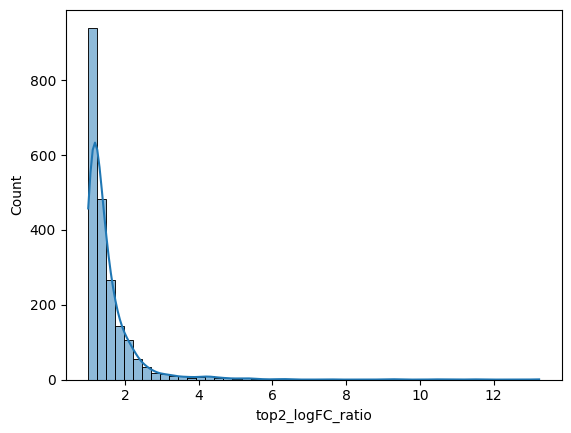

In [121]:
sns.histplot(top2_logFC_ratio, bins=50, kde=True)
plt.show()

In [122]:
top2_logFC_ratio.sort_values(ascending=False).head()

gene
Desi1    13.236698
Sgms1    11.465485
Mbp      10.458092
Igf1r     9.308283
Bsg       9.094425
Name: top2_logFC_ratio, dtype: float64

In [123]:
df[df.gene == "Desi1"].head(3)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,significant_positive
Desi1,Desi1,Oligodendrocytes,Oligodendrocytes_vs_others,2.345713,5.083115,8.908804,2305.828590,0.000000,0.000000,inf,True,True
Desi1,Desi1,Bergmann,Bergmann_vs_others,0.177213,1.130697,8.908804,0.733656,0.391757,0.532439,0.406983,False,False
Desi1,Desi1,ABCs,ABCs_vs_others,0.159733,1.117080,8.908804,0.596208,0.440078,0.574609,0.356470,False,False


In [124]:
top2_logFC_ratio.sort_values(ascending=False).tail(805)

gene
Ndufa4           1.200856
C130073E24Rik    1.200786
Srgap1           1.200540
Fam107a          1.200314
Gabra1           1.198967
                   ...   
Rbpms            1.000615
Sobp             1.000570
Ccdc85a          1.000534
Gnas             1.000464
Cp               1.000446
Name: top2_logFC_ratio, Length: 805, dtype: float64

In [125]:
df[df.gene == "Ndufa4"].head(3)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,significant_positive
Ndufa4,Ndufa4,Neurons-Dopa-Gaba,Neurons-Dopa-Gaba_vs_others,0.735884,1.665418,9.447316,52.242219,6.230568e-13,2.269250e-12,12.205472,False,False
Ndufa4,Ndufa4,Neurons-Gaba,Neurons-Gaba_vs_others,0.612799,1.529224,9.447316,204.006740,8.608237e-45,2.317686e-44,44.065086,False,False
Ndufa4,Ndufa4,Neurons-Immature,Neurons-Immature_vs_others,0.430268,1.347484,9.447316,24.506369,7.825883e-07,2.522069e-06,6.106467,False,False


In [126]:
df = df.join(top2_logFC_ratio)

In [127]:
df_sign = df[df["significant_positive"]]
df_sign.shape

(2606, 13)

In [128]:
df_sign[df_sign["gene"] == "Acta2"]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,significant_positive,top2_logFC_ratio
Acta2,Acta2,SMCs,SMCs_vs_others,7.778357,219.542557,7.618506,2786.469635,0.000000e+00,0.000000e+00,inf,True,True,2.107137
Acta2,Acta2,Ependymal,Ependymal_vs_others,3.691434,12.919104,7.618506,185.848560,5.637256e-41,1.347241e-39,40.248932,True,True,2.107137
Acta2,Acta2,Pericytes,Pericytes_vs_others,2.801303,6.970699,7.618506,255.863194,4.292688e-55,3.498294e-54,54.367271,True,True,2.107137
Acta2,Acta2,ECs,ECs_vs_others,2.540462,5.817754,7.618506,307.881701,2.334982e-65,1.011509e-64,64.631716,True,True,2.107137
Acta2,Acta2,VLMCs,VLMCs_vs_others,2.129822,4.376633,7.618506,88.560595,1.019609e-20,5.707125e-20,19.991567,True,True,2.107137


In [178]:
df_sign[df_sign["gene"] == "Cdh5"]

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,significant_positive,top2_logFC_ratio
Cdh5,Cdh5,ECs,ECs_vs_others,6.453941,87.665708,7.234674,3022.018196,0.000000e+00,0.000000e+00,inf,True,True,1.19018
Cdh5,Cdh5,ABCs,ABCs_vs_others,5.422657,42.892617,7.234674,242.822139,8.970328e-52,4.769972e-49,51.047192,True,True,1.19018
Cdh5,Cdh5,VLMCs,VLMCs_vs_others,5.215331,37.151055,7.234674,1394.752146,2.469463e-232,1.945388e-230,231.607398,True,True,1.19018
Cdh5,Cdh5,BAMs,BAMs_vs_others,2.107226,4.308621,7.234674,57.286511,5.701604e-14,2.521271e-13,13.244003,True,True,1.19018
Cdh5,Cdh5,SMCs,SMCs_vs_others,2.017549,4.048952,7.234674,86.269240,3.942774e-20,1.843139e-19,19.404198,True,True,1.19018


In [173]:
# exclude genes with low top2_logFC_ratio
df_sign_spec = df_sign[df_sign["top2_logFC_ratio"] > 1.1]
df_sign_spec.shape

(1891, 13)

In [174]:
# Get top 20 per cell type
dftemp = df_sign_spec.copy()
dftemp = dftemp.sort_values(by=["logFC"], ascending=[False])
top20_per_type = {}
for cell_type in dftemp["cell_type"].unique():
    top20_per_type[cell_type] = (
        dftemp[dftemp["cell_type"] == cell_type]["gene"].head(10).tolist()
    )

In [175]:
result = pd.DataFrame(top20_per_type)

In [176]:
result

,Ependymal,Pericytes,SMCs,Microglia,Neurons-Dopa-Gaba,ECs,Neurons-Immature,Oligodendrocytes,OECs,VLMCs,...,BAMs,OPCs,ABCs,Neurons-Gaba,Astrocytes,Bergmann,Neurons-Glyc-Gaba,Neurons-Other,Neurons-Dopa,Neurons-Glut
0,Ccdc153,Higd1b,Acta2,Ccl4,Trh,Flt1,Igfbpl1,Plp1,Fabp7,Slc6a13,...,Spi1,Neu4,Cdh5,Gm14033,Gpc5,Fmod,Ttr,Sgcz,Cyyr1,Slc17a7
1,Ttr,Ndufa4l2,Map3k7cl,C1qc,Lgr5,Cldn5,Dlx6os1,9630013A20Rik,Npy,Dcn,...,Fcrls,Pdgfra,Dcn,Vip,Gm6145,1700047M11Rik,Lamp5,Gm12239,Dnah12,Slc17a6
2,Tmem212,Kcnj8,Myh11,C1qb,Sall3,Ly6c1,Gm17750,Enpp6,Apod,Fmod,...,Cd300c2,Olig2,Fmod,Car8,Slco1c1,Dynlrb2,Spp1,Nrg1,Vip,C1ql3
3,Dnah12,Abcc9,Tagln,C1qa,Stac,Adgrl4,Sox11,C030029H02Rik,Sntb1,Igf2,...,Fcgr3,C1ql1,Tmem119,Grid2,Gm20713,Gm6145,Gm12239,March11,Syndig1l,Nrn1
4,Dynlrb2,Tbx3os1,Higd1b,Siglech,Syndig1l,Slco1a4,Cd24a,Opalin,Igf1,Ptgds,...,Gm10790,Gm32509,Igf2,Sst,Slc1a3,Gm19935,Stac,Ttr,Gm32509,Nrgn
5,Gm19935,Vtn,Pln,Spi1,Pax6,Ly6a,Pax6,Cldn11,Ptn,Lama1,...,C1qc,Lhfpl3,Abcb1a,Dlx6os1,Gja1,Slc7a10,Slc1a6,Chrm2,Nostrin,Ptprd
6,3300002A11Rik,Ifitm1,Ndufa4l2,Tnf,Chrm2,Foxq1,Dcx,Fa2h,Hes5,Foxq1,...,Ltc4s,Gm20713,Spp1,Arhgef33,Gm12239,Col1a2,March11,9530059O14Rik,Stac,Ttr
7,Rarres2,Cox4i2,Mustn1,Ccl3,Dlx6os1,Ctla2a,Meis2,Ermn,Vtn,Cdh5,...,Csf3r,Hes5,Paqr5,Slc1a6,Aqp4,Ranbp3l,Gm14033,Stac,Fgd5,Kcnip4
8,Spag16,Rgs5,Myl9,Fcrls,Nxph1,Cdh5,Sall3,Mog,Plp1,Col4a6,...,Ikzf1,Pllp,Col1a2,Npy,S1pr1,Spag16,Lama1,Trh,Slc1a6,Meg3
9,Cfap299,Slc6a20a,Crispld2,Cd300c2,Nrsn1,Cd93,Tubb2b,Mal,Kctd12,Ifitm1,...,Siglech,Emid1,Mustn1,Meg3,Slc7a10,Rfx4,Gm32509,Gm32509,Gm12239,Cck


In [177]:
# number of duplicates genes
duplicates = {
    key: value
    for key, value in collections.Counter(result.values.flatten()).items()
    if value > 1
}
len(duplicates)

46

In [166]:
# Save
# result.to_csv(os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "marker_genes_df", date.today().strftime("%Y%m%d") + "_cell_type_markers_top20.csv"), index=False)
# os.path.join(main_dir, "ABCAtlas_Yao2023Nature", "marker_genes_df", date.today().strftime("%Y%m%d") + "_cell_type_markers_top20.csv")

### Option D: logFC variance

Not used

Variance of logFC per gene (across cell types)  

Issues:
- high variance does not imply specificity among top cell types, but rather specificity across ALL cell types. not of primary interest.

In [450]:
def sd_per_gene(df, metric="logFC"):
    return df.groupby("gene").apply(lambda g: g[metric].std()).rename("sd")

In [451]:
sd_logFC = sd_per_gene(df, metric="logFC")

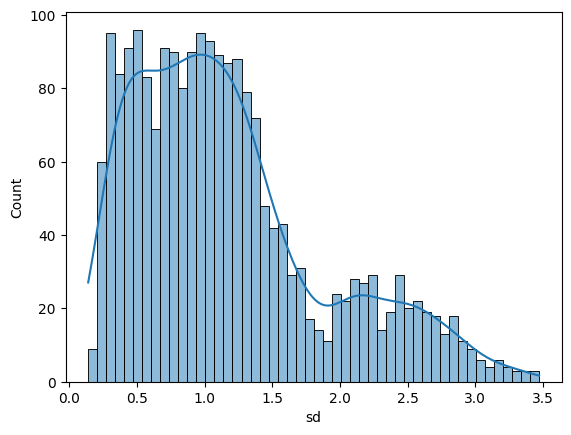

In [458]:
sns.histplot(sd_logFC, bins=50, kde=True)
plt.show()

In [463]:
sd_logFC.sort_values(ascending=False)

gene
Tbx18     3.473004
Adap2     3.449117
Ifitm3    3.407220
Cfh       3.382905
Igf2      3.381070
            ...   
Tnrc6b    0.194954
Eif4g3    0.191914
Fus       0.171370
Usp34     0.162140
Arid1b    0.138449
Name: sd, Length: 2127, dtype: float64

In [469]:
df[df.gene == "Tbx18"].head(3)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,SD_logFC
Tbx18,Tbx18,VLMCs,VLMCs_vs_others,6.581926,95.798174,6.793558,4451.594912,0.0,0.0,inf,True,NaN
Tbx18,Tbx18,SMCs,SMCs_vs_others,6.069905,67.177441,6.793558,3191.264263,0.0,0.0,inf,True,NaN
Tbx18,Tbx18,Pericytes,Pericytes_vs_others,5.996477,63.843889,6.793558,3673.146173,0.0,0.0,inf,True,NaN


In [470]:
df[df.gene == "Tbx18"].tail(3)

,gene,cell_type,test,logFC,FC,logCPM,F,PValue,FDR,nlog(pvalue),significant,SD_logFC
Tbx18,Tbx18,Neurons-Dopa-Gaba,Neurons-Dopa-Gaba_vs_others,-2.547626,0.171036,6.793558,7.740128e-12,0.999998,0.999999,9.638912e-07,False,2.659884
Tbx18,Tbx18,Neurons-Other,Neurons-Other_vs_others,-2.655177,0.158749,6.793558,6.829525e-13,0.999999,0.999999,2.863181e-07,False,2.679842
Tbx18,Tbx18,Immune-Other,Immune-Other_vs_others,-2.734607,0.150245,6.793558,1.847308e+00,0.174297,0.269818,7.587103e-01,False,2.703363


# Correlate excllib and incllib (QL)

exploratory

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [ ]:
setdate = ""  # ?

In [56]:
df2 = pd.read_csv(
    os.path.join(
        main_dir,
        "ABCAtlas_Yao2023Nature",
        "marker_genes_df",
        setdate + "_DEA_QL_strict_incllib.csv",
    ),
    index_col=0,
)

In [95]:
df.index = df["gene"].astype(str) + "_" + df["cell_type"].astype(str)

In [96]:
df2.index = df2["gene"].astype(str) + "_" + df2["cell_type"].astype(str)

In [97]:
df.shape

(44667, 11)

In [98]:
df2.shape

(44667, 9)

In [99]:
pearsonr(df["logFC"], df2["logFC"])

PearsonRResult(statistic=0.999293194913752, pvalue=0.0)

In [100]:
pearsonr(df["PValue"], df2["PValue"])

PearsonRResult(statistic=0.4882997728909626, pvalue=0.0)

In [101]:
merge = df.join(df2, how="left", lsuffix="", rsuffix="_2")

In [102]:
merge.shape

(44667, 20)

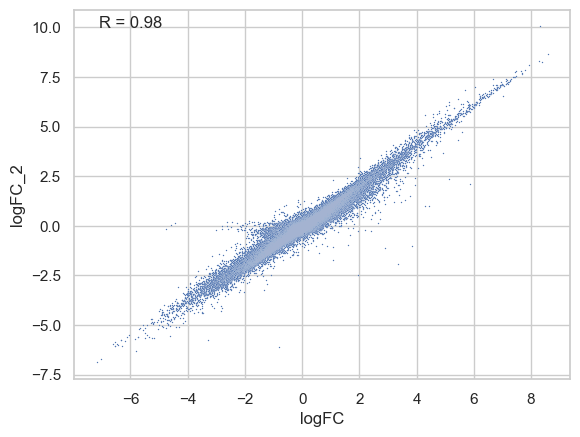

In [107]:
r, _ = pearsonr(merge["logFC"], merge["logFC_2"])
sns.scatterplot(x=merge["logFC"], y=merge["logFC_2"], s=1)
plt.text(0.05, 0.95, f"R = {r:.2f}", transform=plt.gca().transAxes)
plt.show()

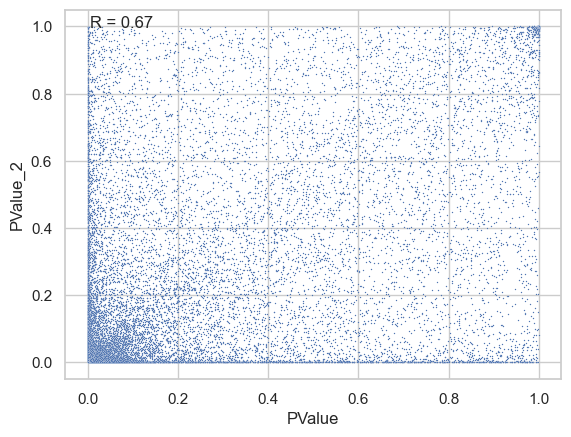

In [108]:
r, _ = pearsonr(merge["PValue"], merge["PValue_2"])
sns.scatterplot(x=merge["PValue"], y=merge["PValue_2"], s=1)
plt.text(0.05, 0.95, f"R = {r:.2f}", transform=plt.gca().transAxes)
plt.show()